In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

2023-12-20 21:54:59.227092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-20 21:54:59.227165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
train_dir = '/home/hermit/Документы/IPT-DataAnalysis-course/lab4/train/'
filepaths = []
labels = []
images = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        img = image.load_img(foldpath+'/'+file, target_size=(64, 64))
        images.append(image.img_to_array(img))
images = np.array(images)
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
1,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
2,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
3,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
4,/home/hermit/Документы/IPT-DataAnalysis-course...,Bodhi Rook
...,...,...
4722,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma
4723,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma
4724,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma
4725,/home/hermit/Документы/IPT-DataAnalysis-course...,Captain Phasma


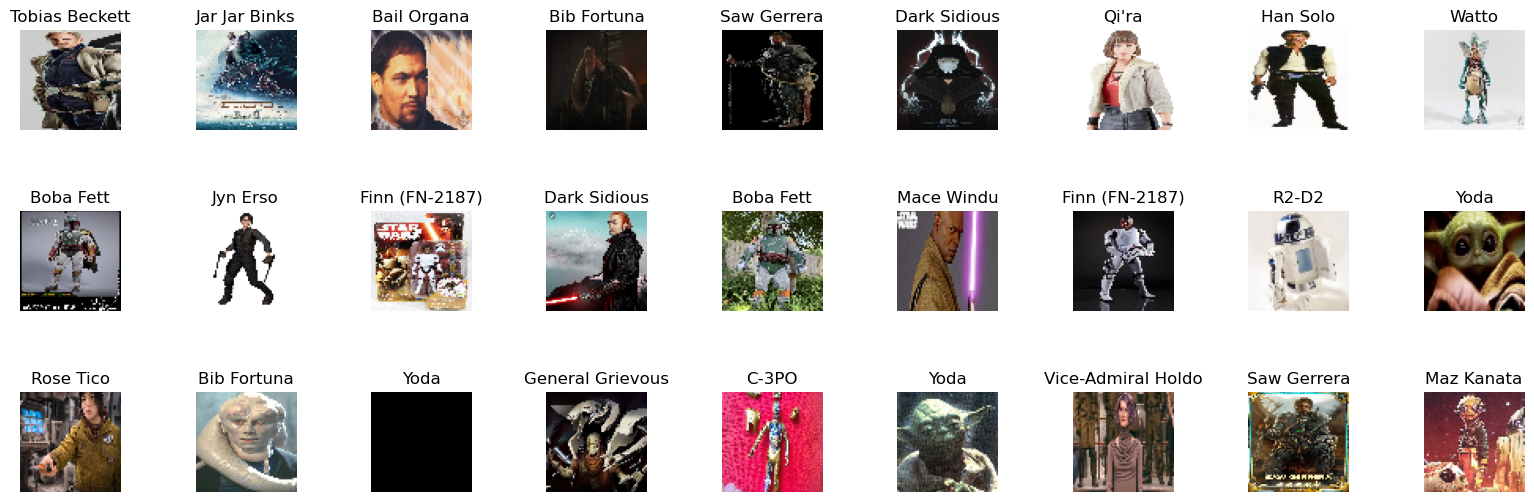

In [5]:
plt.figure(figsize=(20, 6))
plt.rcParams['font.size'] = 10
for i in range(27):
    plt.subplot(3,9,i+1)
    plt.axis('off')
    j = int(np.random.randint(0,images.shape[0],1))
    plt.imshow(images[j]/255)
    plt.title(train_df.labels[j])
    plt.subplots_adjust(hspace=.8)

In [6]:
train_df.labels.value_counts()[:20]

Admiral Ackbar          100
Greedo                   99
Princess Leia Organa     98
Luke Skywalker           98
Wedge Antilles           97
Rey                      97
C-3PO                    97
Chewbacca                96
Kenobi                   96
Jar Jar Binks            96
Dark Sidious             96
Jango Fett               95
Grand Moff Tarkin        95
Yoda                     95
Cassian Andor            95
Captain Phasma           95
Jyn Erso                 95
Nien Nunb                94
Qui-Gon Jinn             94
Poe Dameron              94
Name: labels, dtype: int64

In [7]:
X_train = [images[i] for i in np.where(train_df.labels=='BB-8')][0]

In [8]:
X_train.shape

(91, 64, 64, 3)

In [9]:
input_dim = 64*64*3
X_train = X_train.reshape(X_train.shape[0], input_dim)
print('input shape: ', X_train.shape[1])
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

input shape:  12288


In [10]:
X_train.shape

(91, 12288)

In [11]:
from tensorflow.keras.optimizers.legacy import Adam

optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [12]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(512*2, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
        
    model.add(layers.Dense(256*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(128*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [13]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(128*2, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(256*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model 

In [14]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

2023-12-20 21:57:26.681742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-20 21:57:26.681815: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-20 21:57:26.681875: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2023-12-20 21:57:26.682430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
def plot_generated_images(epoch, generator):
    num_of_images = 5
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise,verbose=0).reshape(num_of_images, 64,64,3)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 5, i+1)
        plt.imshow((generated_images[i]/2+0.5))
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [16]:
discrim_losses = []
generator_losses = []

def train_model(epochs, batch_size):
    d_loss = 0
    gan_loss=0
    num_batches = int(X_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
             # Generate fake MNIST images
            generated_images = generator.predict(noise,verbose=0)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(noise, y_gen)
            generator_losses.append(gan_loss)

        if ep % 100 == 0:
            print('epoch: ', ep)
            print(ep, "discriminator loss: ", d_loss,"generator loss: ", gan_loss)
            plot_generated_images(ep, generator)

In [17]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              12583936  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [18]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 12288)            

epoch:  0
0 discriminator loss:  0.7200289964675903 generator loss:  0.6033443212509155


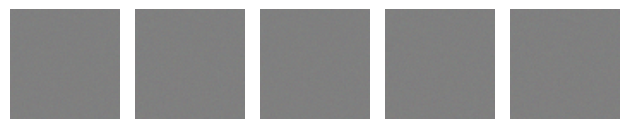

epoch:  100
100 discriminator loss:  0.49534550309181213 generator loss:  0.9305580854415894


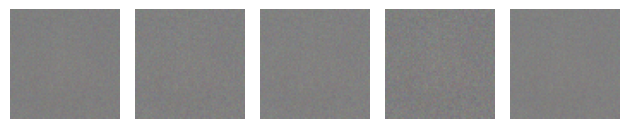

epoch:  200
200 discriminator loss:  0.6241306066513062 generator loss:  1.144190788269043


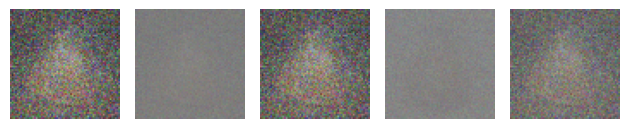

epoch:  300
300 discriminator loss:  0.5598492622375488 generator loss:  1.7354971170425415


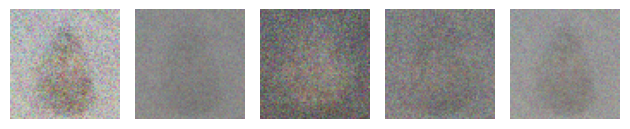

epoch:  400
400 discriminator loss:  0.40148699283599854 generator loss:  1.505918025970459


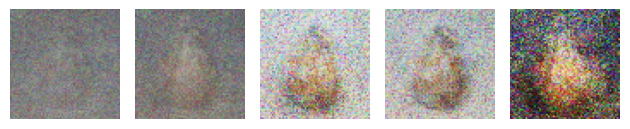

epoch:  500
500 discriminator loss:  0.4700011610984802 generator loss:  2.0765671730041504


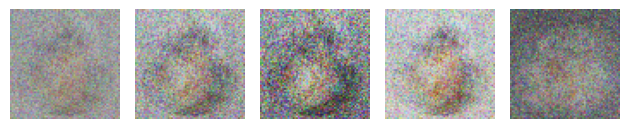

In [19]:
epochs = 500
batch_size = 32
train_model(epochs, batch_size)

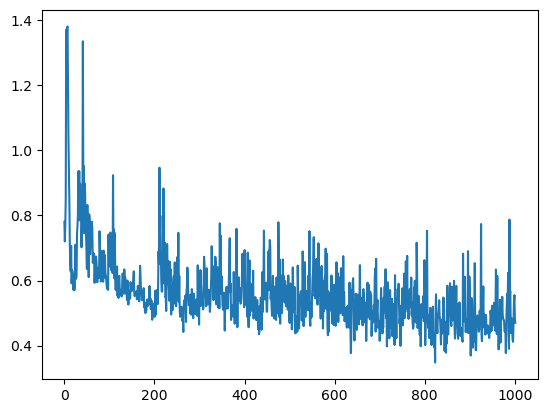

In [20]:
plt.plot(discrim_losses)